In [87]:
# import modules
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset
from scipy import ndimage
import statistics

## Data Prepare

In [2]:
class ROOTDIR:
    train = "/home/minjung/final_project/training_images"
    train_mask = "/home/minjung/final_project/training_masks"

In [3]:
train_img_lst = [i for i in os.listdir(ROOTDIR.train) if i.split('.')[-1]=='png']
train_mask_lst = [i for i in os.listdir(ROOTDIR.train_mask) if i.split('.')[-1]=='png']

In [4]:
sorted_train_mask_lst = sorted(train_mask_lst)
sorted_train_img_lst = sorted(train_img_lst)

In [64]:
print("img_num: ", len(sorted_train_img_lst))
print("mask_num: ", len(sorted_train_mask_lst))

img_num:  381
mask_num:  381


/home/minjung/final_project/training_images/10.png
(512, 512)
<class 'PIL.PngImagePlugin.PngImageFile'>


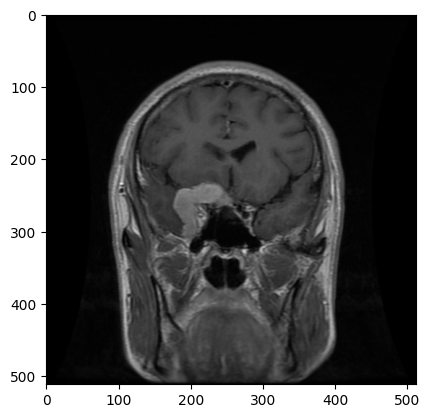

/home/minjung/final_project/training_masks/10.png
(512, 512)


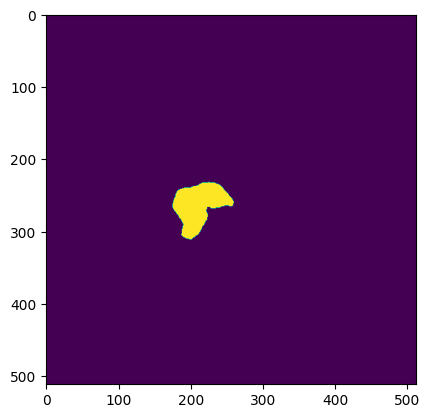

----------------------------------------------------
/home/minjung/final_project/training_images/100.png
(512, 512)
<class 'PIL.PngImagePlugin.PngImageFile'>


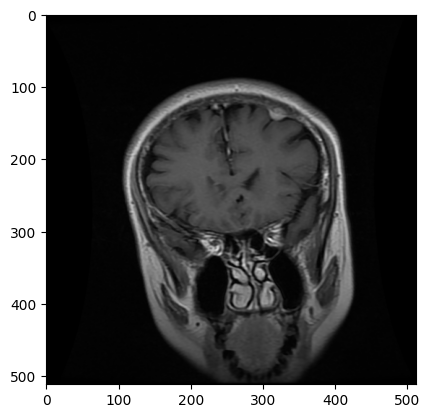

/home/minjung/final_project/training_masks/100.png
(512, 512)


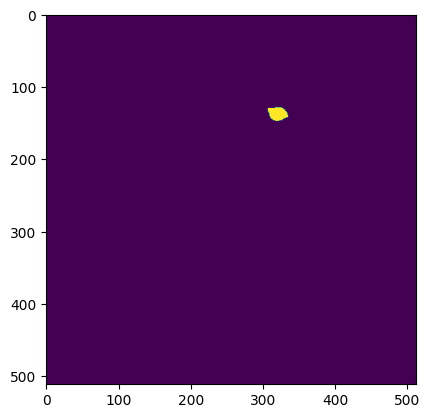

----------------------------------------------------


In [6]:
def show_images(imgs_lst,masks_lst,loops=2):
    for i in range(loops):
        img_path = os.path.join(ROOTDIR.train,imgs_lst[i])
        mask_path = os.path.join(ROOTDIR.train_mask,masks_lst[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(sorted_train_img_lst, sorted_train_mask_lst)

## Model

In [7]:
class CFG:
    device = torch.device("cuda:0")
    split_pct = 0.2
    learning_rate = 3e-4
    batch_size = 8
    epochs = 10000

In [8]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [9]:
permuted_train_img_lst = np.random.permutation(np.array(sorted_train_img_lst))
permuted_train_mask_lst = [x for x in permuted_train_img_lst]

/home/minjung/final_project/training_images/194.png
(512, 512)
<class 'PIL.PngImagePlugin.PngImageFile'>


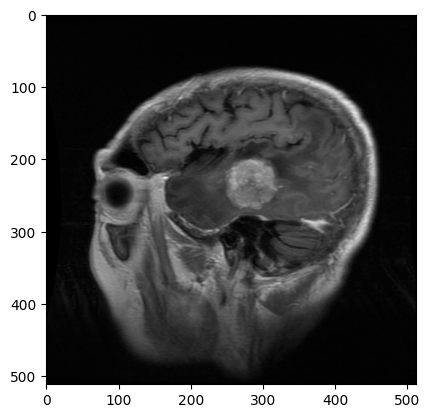

/home/minjung/final_project/training_masks/194.png
(512, 512)


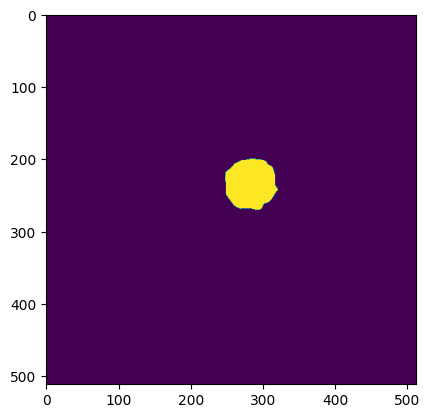

----------------------------------------------------
/home/minjung/final_project/training_images/182.png
(512, 512)
<class 'PIL.PngImagePlugin.PngImageFile'>


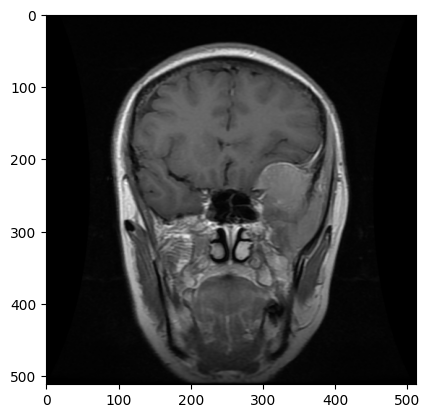

/home/minjung/final_project/training_masks/182.png
(512, 512)


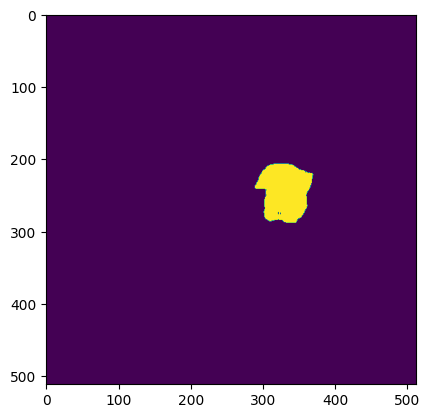

----------------------------------------------------


In [10]:
show_images(permuted_train_img_lst,permuted_train_mask_lst)

In [11]:
train_images_list = permuted_train_img_lst[int(CFG.split_pct*len(permuted_train_img_lst)) :]
train_masks_list = permuted_train_mask_lst[int(CFG.split_pct*len(permuted_train_mask_lst)) :]
print(len(train_masks_list))

val_images_list = permuted_train_img_lst[: int(CFG.split_pct*len(permuted_train_img_lst))]
val_masks_list = permuted_train_mask_lst[: int(CFG.split_pct*len(permuted_train_mask_lst))]
print(len(val_masks_list))

305
76


In [12]:
class Dataset(Dataset):
    def __init__(self,img_list,mask_list,transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,index):
        img_path = os.path.join(ROOTDIR.train,self.img_list[index])
        mask_path = os.path.join(ROOTDIR.train_mask,self.mask_list[index])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0
        #img_mask_dict = {"image": img, "mask": mask}

        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
            #transformations = self.transform(image=img, mask=mask)
            #img = transformations["image"]
            #mask = transformations["mask"]
            
        return img,mask

In [13]:
train_transform = A.Compose([A.Resize(512,512), 
                             A.HorizontalFlip(p=0.5),
                             A.ColorJitter(saturation=(0.2,3)),
                             A.Rotate(limit=30, p=0.5),
                             A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(512,512),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [14]:
train_dataset = Dataset(train_images_list, train_masks_list, transform = train_transform)
val_dataset = Dataset(val_images_list, val_masks_list, transform = train_transform)

In [15]:
train_dataloader = DataLoader(train_dataset,batch_size=CFG.batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False)

In [16]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv

def padder(left_tensor, right_tensor): 
    # left_tensor is the tensor on the encoder side of UNET
    # right_tensor is the tensor on the decoder side  of the UNET
    
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(CFG.device)
    
    return right_tensor.to(CFG.device)

In [17]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        #print(self.down_conv_1)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)

        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)

        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)

    def forward(self,x):
        # encoding
        x1 = self.down_conv_1(x)
        #print("X1", x1.shape)
        p1 = self.max_pool(x1)
        #print("p1", p1.shape)
        x2 = self.down_conv_2(p1)
        #print("X2", x2.shape)
        p2 = self.max_pool(x2)
        #print("p2", p2.shape)
        x3 = self.down_conv_3(p2)
        #print("X2", x3.shape)
        p3 = self.max_pool(x3)
        #print("p3", p3.shape)
        x4 = self.down_conv_4(p3)
        #print("X4", x4.shape)
        p4 = self.max_pool(x4)
        #print("p4", p4.shape)
        x5 = self.down_conv_5(p4)
        #print("X5", x5.shape)

        # decoding
        d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
        pad1 = padder(x4,d1) # padding d1 to match x4 shape
        cat1 = torch.cat([x4,pad1],dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
        uc1 = self.up_conv_1(cat1) # 1st up double convolution
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)

        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1
        #print(conv_1x1.shape)

In [18]:
def iou_score(output, target):
    smooth = 1e-6

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

In [19]:
def train_model(model,dataloader,criterion,optimizer):
    model.train()
    train_running_loss = 0.0
    iou_score_total = 0

    for j,img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().to(CFG.device)
        mask = img_mask[1].float().to(CFG.device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        loss = criterion(y_pred,mask)
        train_running_loss += loss.item() * CFG.batch_size
        loss.backward()
        optimizer.step()

        iou_score_total += iou_score(y_pred, mask)
        
    train_loss = train_running_loss / (j+1)
    avg_iou_score = iou_score_total / (j+1)

    return train_loss, avg_iou_score

In [20]:
def val_model(model,dataloader,criterion,optimizer):
    model.eval()

    val_running_loss = 0
    iou_score_total = 0

    with torch.no_grad():
        for j,img_mask in enumerate(tqdm(dataloader)):
            img = img_mask[0].float().to(CFG.device)
            mask = img_mask[1].float().to(CFG.device)
            y_pred = model(img)
            loss = criterion(y_pred,mask)
            
            val_running_loss += loss.item() * CFG.batch_size

            iou_score_total += iou_score(y_pred, mask)
            
        val_loss = val_running_loss / (j+1)
        avg_iou_score = iou_score_total / (j+1)
    return val_loss, avg_iou_score

In [21]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.bce = nn.BCEWithLogitsLoss()
        
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice = dice_loss(torch.sigmoid(pred), target)
        loss = self.alpha * bce_loss + self.beta * dice
        return loss

In [22]:
model = UNET(in_chnls = 3, n_classes = 1).to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr = CFG.learning_rate)
criterion = CombinedLoss()
train_loss_lst = []
val_loss_lst = []  
train_iou_lst = []
val_iou_lst = []

## Training

In [23]:
# setting for early stopping
best_val_loss = float('inf')
patience = 15
counter_early_stop = 0
delta = 0.0001

# training
for i in tqdm(range(CFG.epochs)):
    train_loss, train_iou = train_model(model=model,dataloader=train_dataloader,criterion=criterion,optimizer=optimizer)
    val_loss, val_iou = val_model(model=model,dataloader=val_dataloader,criterion=criterion,optimizer=optimizer)
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)
    train_iou_lst.append(train_iou)
    val_iou_lst.append(val_iou)
    
    print(f" Train Loss : {train_loss:.4f}")
    print(f" Validation Loss : {val_loss:.4f}")

    if val_loss < best_val_loss - delta:
        best_val_loss = val_loss
        counter_early_stop = 0
    else:
        counter_early_stop += 1

    if counter_early_stop >= patience:
        print("Early stopping with best_val_loss: ", best_val_loss)
        break

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 5.3243
 Validation Loss : 5.2204


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 4.8249
 Validation Loss : 5.8100


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 4.5872
 Validation Loss : 4.5875


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 4.3825
 Validation Loss : 4.3695


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 4.1691
 Validation Loss : 4.1793


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 3.9435
 Validation Loss : 4.0022


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 3.7602
 Validation Loss : 3.9512


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 3.6430
 Validation Loss : 3.7240


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 3.3551
 Validation Loss : 3.4490


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 3.1448
 Validation Loss : 3.4735


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 2.9570
 Validation Loss : 4.0749


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 2.6539
 Validation Loss : 2.6815


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 2.4210
 Validation Loss : 2.4657


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 2.2256
 Validation Loss : 2.4801


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 2.0360
 Validation Loss : 2.3892


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.8781
 Validation Loss : 2.2192


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.7877
 Validation Loss : 2.1583


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.7239
 Validation Loss : 2.3492


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.7925
 Validation Loss : 2.0648


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.5275
 Validation Loss : 1.8460


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.6003
 Validation Loss : 1.9945


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.4806
 Validation Loss : 1.7428


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.4354
 Validation Loss : 2.0571


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.4101
 Validation Loss : 4.2959


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.3640
 Validation Loss : 1.9741


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.3088
 Validation Loss : 1.9714


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.4150
 Validation Loss : 2.7264


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.3016
 Validation Loss : 1.8729


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.2019
 Validation Loss : 2.8926


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.2768
 Validation Loss : 1.6625


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.0771
 Validation Loss : 1.6623


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.0405
 Validation Loss : 1.6569


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.0788
 Validation Loss : 1.4312


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9375
 Validation Loss : 1.2819


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8876
 Validation Loss : 1.3027


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9635
 Validation Loss : 1.4679


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.1593
 Validation Loss : 1.4959


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9990
 Validation Loss : 1.3864


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9190
 Validation Loss : 4.2666


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.0551
 Validation Loss : 1.3072


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9322
 Validation Loss : 1.3026


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9083
 Validation Loss : 1.2640


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9280
 Validation Loss : 1.5382


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9614
 Validation Loss : 1.3398


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9208
 Validation Loss : 2.0226


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8834
 Validation Loss : 1.2728


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8677
 Validation Loss : 1.4063


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8508
 Validation Loss : 1.3779


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8318
 Validation Loss : 2.9349


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8537
 Validation Loss : 1.2362


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7588
 Validation Loss : 1.2848


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7676
 Validation Loss : 1.2223


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7732
 Validation Loss : 1.1463


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8841
 Validation Loss : 1.3394


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7461
 Validation Loss : 1.2866


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8324
 Validation Loss : 1.0160


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8052
 Validation Loss : 1.2962


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7337
 Validation Loss : 1.3565


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7652
 Validation Loss : 1.1125


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7008
 Validation Loss : 1.3469


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6414
 Validation Loss : 1.2705


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6862
 Validation Loss : 1.2575


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6968
 Validation Loss : 1.3274


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7321
 Validation Loss : 1.2173


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6795
 Validation Loss : 1.4684


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6711
 Validation Loss : 1.1014


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6233
 Validation Loss : 1.0115


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6366
 Validation Loss : 1.2215


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6392
 Validation Loss : 1.3481


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6065
 Validation Loss : 1.0780


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6345
 Validation Loss : 1.3227


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7081
 Validation Loss : 1.3338


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6147
 Validation Loss : 1.0817


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6459
 Validation Loss : 1.2129


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6994
 Validation Loss : 1.0809


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6830
 Validation Loss : 1.1896


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6554
 Validation Loss : 0.9956


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6245
 Validation Loss : 1.1689


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5743
 Validation Loss : 1.0691


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5574
 Validation Loss : 1.1881


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5621
 Validation Loss : 1.0228


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5853
 Validation Loss : 1.0056


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6832
 Validation Loss : 1.0894


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6436
 Validation Loss : 1.1298


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6122
 Validation Loss : 1.1027


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5738
 Validation Loss : 0.9505


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6879
 Validation Loss : 1.1591


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6324
 Validation Loss : 1.0385


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5611
 Validation Loss : 1.0394


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5610
 Validation Loss : 1.1763


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6179
 Validation Loss : 1.6357


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6533
 Validation Loss : 1.1864


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6570
 Validation Loss : 1.0373


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.4817
 Validation Loss : 0.9718


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6618
 Validation Loss : 1.2028


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5525
 Validation Loss : 1.0953


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5483
 Validation Loss : 1.1137


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5153
 Validation Loss : 0.9670


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.4843
 Validation Loss : 0.9613


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5697
 Validation Loss : 1.0441


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.4853
 Validation Loss : 1.1999
Early stopping with best_val_loss:  0.9505369663238525


## Save Trained Model

In [27]:
TRAINED_FILE = "/home/minjung/final_project/unet_final_model_.pth"
torch.save(model.state_dict(), TRAINED_FILE)

## Inference

In [28]:
trained_model = UNET(in_chnls = 3, n_classes = 1)
UNET_TRAINED = "/home/minjung/final_project/unet_final_model_.pth"
trained_model.load_state_dict(torch.load(UNET_TRAINED))

<All keys matched successfully>

In [29]:
trained_model = trained_model.to("cuda:0")
trained_model.eval()

UNET(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=

In [30]:
test_transform = A.Compose([A.Resize(512,512),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

### Inference for Entire Images

In [31]:
inference_img = os.listdir("/home/minjung/final_project/BrainTumor_image")

In [40]:
for i in inference_img:
    if(i.split('.')[-1]=='png'):
        path = "/home/minjung/final_project/BrainTumor_image/"
        img  = cv2.imread(path+i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.array(img)
        test_image = test_transform(image = img)
        img = test_image["image"].unsqueeze(0)
        img = img.to("cuda:0")
        pred = trained_model(img)
        mask = pred.squeeze(0).cpu().detach().numpy()
        mask[mask < 0]=0
        mask[mask > 0]=1
        mask = np.where(mask==1, 255, 0)
        mask = mask.astype(np.uint8)
        if(mask.shape==(1,512,512)):
            original_sized = cv2.resize(mask[0], dsize=(512,512), interpolation=cv2.INTER_LINEAR)
        else:
            original_sized = cv2.resize(mask, dsize=(512,512), interpolation=cv2.INTER_LINEAR)
        cv2.imwrite("/home/minjung/final_project/Entire_Inference/"+i,original_sized)

In [44]:
class1_img = [i for i in os.listdir("/home/minjung/final_project/class1_image")]
class2_img = [i for i in os.listdir("/home/minjung/final_project/class3_image")]

inference_img2 = class1_img + class2_img

In [45]:
for i in inference_img2:
    if(i.split('.')[-1]=='png'):
        path = "/home/minjung/final_project/BrainTumor_image/"
        img  = cv2.imread(path+i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.array(img)
        test_image = test_transform(image = img)
        img = test_image["image"].unsqueeze(0)
        img = img.to("cuda:0")
        pred = trained_model(img)
        mask = pred.squeeze(0).cpu().detach().numpy()
        mask[mask < 0]=0
        mask[mask > 0]=1
        mask = np.where(mask==1, 255, 0)
        mask = mask.astype(np.uint8)
        if(mask.shape==(1,512,512)):
            original_sized = cv2.resize(mask[0], dsize=(512,512), interpolation=cv2.INTER_LINEAR)
        else:
            original_sized = cv2.resize(mask, dsize=(512,512), interpolation=cv2.INTER_LINEAR)
        cv2.imwrite("/home/minjung/final_project/Class1_Class3_Result/"+i,original_sized)

## Check

In [63]:
# count black image
directory = '/home/minjung/final_project/Entire_Inference'
black_img = []

for filename in os.listdir(directory):
    if filename.endswith(".png"):
        image_path = os.path.join(directory, filename)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if cv2.countNonZero(image) == 0:
            black_img.append(filename)
        else:
            cv2.imwrite("/home/minjung/final_project/Inference_Result/"+filename, image)

In [ ]:
label_npy = np.load("/home/minjung/final_project/labels.npy", allow_pickle=True)

indices_1 = list(np.where(label_npy == 1)[0])
indices_2 = list(np.where(label_npy == 2)[0])
indices_3 = list(np.where(label_npy == 3)[0])

In [53]:
black_img_idx = [int(i.split('.')[0]) for i in black_img]
class1_black = [i for i in black_img_idx if i in indices_1]
class2_black = [i for i in black_img_idx if i in indices_2]
class3_black = [i for i in black_img_idx if i in indices_3]

In [65]:
print("number of black images in total: ", len(black_img_idx))
print("number of black images in class1: ", len(class1_black))
print("number of black images in class2: ", len(class2_black))
print("number of black images in class3: ", len(class3_black))

number of black images in total:  524
number of black images in class1:  25
number of black images in class2:  356
number of black images in class3:  143


#### mdice for each class

In [74]:
no_black_idx = [int(i.split('.')[0]) for i in os.listdir("/home/minjung/final_project/Inference_Result") ]
training_idx = [int(i.split('.')[0]) for i in os.listdir("/home/minjung/final_project/training_images")]

valid_idx = [i for i in training_idx if i in no_black_idx]


class1 = [i for i in valid_idx if i in indices_1]
class2 = [i for i in valid_idx if i in indices_2]
class3 = [i for i in valid_idx if i in indices_3]

In [164]:
def dice_coef(y_true, y_pred, smooth=0.001):
    y_true[y_true>1] = 1
    y_pred[y_pred>1] = 1
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

In [111]:
class_1_pred = []

for i in class1:
    path = '/home/minjung/final_project/Inference_Result/'+str(i)+'.png'
    mask = Image.open(path)
    mask = np.array(mask)
    class_1_pred.append(mask)

class_1_true = []

for i in class1:
    path = '/home/minjung/final_project/training_masks/'+str(i)+'.png'
    mask = Image.open(path)
    mask = np.array(mask)
    class_1_true.append(mask)

In [162]:
class1_dice = []
for i in range(len(class1)):
    mdice = dice_coef(class_1_true[i], class_1_pred[i])
    class1_dice.append(mdice)

In [163]:
print("class1_dice: ", statistics.mean(class1_dice))

class1_dice:  0.9512917110469579


In [148]:
class_2_pred = []

for i in class2:
    path = '/home/minjung/final_project/Inference_Result/'+str(i)+'.png'
    mask = Image.open(path)
    mask = np.array(mask)
    class_2_pred.append(mask)

class_2_true = []

for i in class2:
    path = '/home/minjung/final_project/training_masks/'+str(i)+'.png'
    mask = Image.open(path)
    mask = np.array(mask)
    class_2_true.append(mask)

In [149]:
class2_dice = []
for i in range(len(class2)):
    mdice = dice_coef(class_2_true[i], class_2_pred[i])
    class2_dice.append(mdice)

In [155]:
print("class2_dice: ", statistics.mean(class2_dice))

class2_dice:  0.8211531567514062


In [151]:
class_3_pred = []

for i in class3:
    path = '/home/minjung/final_project/Inference_Result/'+str(i)+'.png'
    mask = Image.open(path)
    mask = np.array(mask)
    class_3_pred.append(mask)

class_3_true = []

for i in class3:
    path = '/home/minjung/final_project/training_masks/'+str(i)+'.png'
    mask = Image.open(path)
    mask = np.array(mask)
    class_3_true.append(mask)

In [152]:
class3_dice = []
for i in range(len(class3)):
    mdice = dice_coef(class_3_true[i], class_3_pred[i])
    class3_dice.append(mdice)

In [154]:
print("class3_dice: ", statistics.mean(class3_dice))

class3_dice:  0.8951018955510989


In [157]:
total_dice = class1_dice + class2_dice + class3_dice
print("total_dice: ", statistics.mean(total_dice))

total_dice:  0.9086593048343646


#### miou for each class

In [158]:
def iou(y_true, y_pred):
    y_true[y_true>1] = 1
    y_pred[y_pred>1] = 1
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [169]:
class1_iou = []
for i in range(len(class1)):
    miou = iou(class_1_true[i], class_1_pred[i])
    class1_iou.append(miou)

In [170]:
print("class1_iou: ", statistics.mean(class1_iou))

class1_iou:  0.9117862304831471


In [171]:
class2_iou = []
for i in range(len(class2)):
    miou = iou(class_2_true[i], class_2_pred[i])
    class2_iou.append(miou)

In [172]:
print("class2_iou: ", statistics.mean(class2_iou))

class2_iou:  0.7457997412911038


In [173]:
class3_iou = []
for i in range(len(class3)):
    miou = iou(class_3_true[i], class_3_pred[i])
    class3_iou.append(miou)

In [174]:
print("class3_iou: ", statistics.mean(class3_iou))

class3_iou:  0.8424409423713574


In [175]:
total_iou = class1_iou + class2_iou + class3_iou
print("total_iou: ", statistics.mean(total_iou))

total_iou:  0.8580208494722663


#### Overlapping

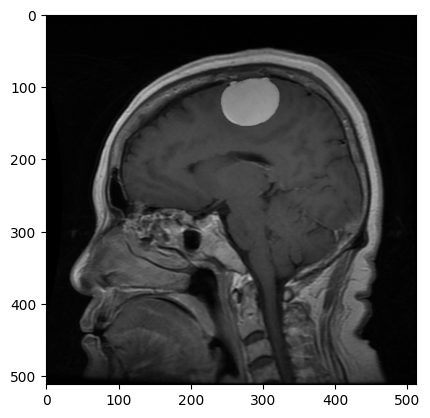

In [136]:
file_num = 2

# 이미지 로드
image = cv2.imread('/home/minjung/final_project/BrainTumor_image/'+str(file_num)+'.png')
mask = cv2.imread('/home/minjung/final_project/Inference_Result/'+ str(file_num) +'.png', cv2.IMREAD_GRAYSCALE)

# 이미지와 마스크의 크기를 맞춰주기 위한 작업
mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

# 마스크를 3채널로 변환
mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

# 투명도 적용을 위해 이미지와 마스크를 [0, 1] 범위로 정규화
image = image / 255.0
mask_colored = mask_colored / 255.0

# 투명도 (알파) 값 설정
alpha = 0.8

# 투명도를 적용한 마스크 이미지 생성
masked_image = (alpha * image) + ((1 - alpha) * mask_colored)

# 이미지 출력
plt.imshow(masked_image)
plt.show()